This notebook is used to make some csv files which highlight top n-grams for features.

In [2]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
import json
import time
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../data/chordonomicon.csv', low_memory=False)

In [3]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())

In [4]:
# read the equivalence dictionary file
# this is a dictionary of dictionaries
#    the top-level keys are chord names (e.g. 'C','Amin')
#    the top-level values are dictionaries, whose keys are equivalent chords, and whose values are the semitone distance between the top-level key and the low-level key
with open('../data/harmonic_equivalence.json') as file:
    equiv_dict = json.load(file)

In [5]:
# drop all columns except for chords and genres
chord_data = df[['chords','genres']]

# drop anything that lacks chord or genre data
chord_data = chord_data.dropna()

In [6]:
# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

In [7]:
# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

In [8]:
# Remove inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

In [9]:
def clean_up_chord_string(my_string):
    return remove_inversions(
        remove_section_markers(
            replace_space_with_comma(my_string)))
    
# cleaning up the data in a few ways
chord_data.loc[:,'chords'] = chord_data['chords'].apply(clean_up_chord_string)

In [10]:
# simplify genre data
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic']
def simplify_genre(genre_string):
    for g in major_genres:
        if g in genre_string:
            return g
    return 'other'

chord_data.loc[:,'genres'] = chord_data['genres'].apply(simplify_genre)
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic','other']

In [11]:
#chord_data.to_csv('chord_and_genre_blank_backup.csv')

In [12]:
full_data_genre_counter = Counter(chord_data.genres)
print(full_data_genre_counter)

Counter({'pop': 131247, 'other': 106961, 'rock': 81276, 'country': 15884, 'punk': 10060, 'alternative': 4358, 'rap': 4013, 'metal': 3007, 'soul': 2909, 'reggae': 2156, 'jazz': 1857, 'electronic': 545})


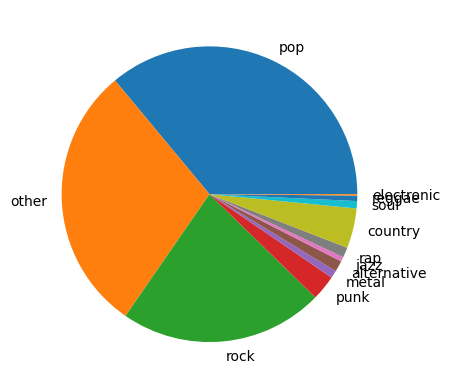

In [13]:
plt.pie(x = list(full_data_genre_counter.values()), 
        labels = list(full_data_genre_counter.keys()))
plt.show()

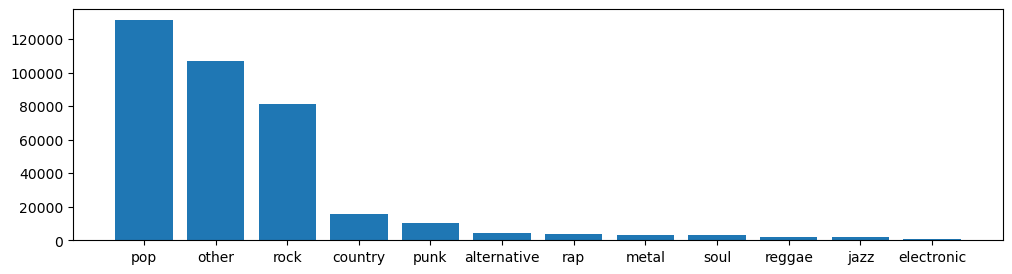

In [14]:
plt.figure(figsize=(12,3))
labels, values = zip(*full_data_genre_counter.most_common())
plt.bar(x = labels, 
        height = values)
plt.show()

In [15]:
# if the two input chords are harmonically equivalent, return (True, num_semitones) where num_semitones is the distance from n_gram_1 (up) to n_gram_2
# otherwise, return (False, None)
def compare_chords(chord_1, chord_2):
    if chord_2 in equiv_dict[chord_1]:
        return (True, equiv_dict[chord_1][chord_2])
    else:
        return (False, None)

print(compare_chords('C','D'))
print(compare_chords('C','E'))
print(compare_chords('C','Amin'))

(True, 2)
(True, 4)
(False, None)


In [16]:
# if the two input n_grams are harmonically equivalent, return (True, num_semitones) where num_semitones is the distance from n_gram_1 (up) to n_gram_2
# otherwise, return (False, None)
def compare_n_grams(n_gram_1, n_gram_2):
    list_1 = n_gram_1.split(',')
    list_2 = n_gram_2.split(',')

    # if they aren't the same length, we don't have to check anything
    if len(list_1) != len(list_2):
        return (False, None)

    # now we can assume they have the same length
    comparison = [compare_chords(list_1[i], list_2[i]) for i in range(len(list_1))]

    # if any pairs are not the same, return False
    for c in comparison:
        if not c[0]:
            return (False, None)

    # now we can assume every respective pair is equivalent, but we still need all of the distances to match
    dist_0 = comparison[0][1]
    for c in comparison:
        if c[1] != dist_0:
            return (False, None)

    return (True, dist_0)

print(compare_n_grams('C,D,E','F,G,A'))
print(compare_n_grams('C,D,E','F,G,B'))

(True, 5)
(False, None)


In [17]:
# return true/false depending on if a song contains a harmonically equivalent n_gram to the input n_gram
# new version of this, making use of the equivalence dictionary for lookups rather than doing calculations every time
def contains_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names

    # skip ahead and return true if the raw version is the song
    if n_gram in song:
        return True

    # split up the song and n_gram into lists of strings of single chords
    song_as_list = song.split(',')
    song_length = len(song_as_list)
    n_gram_as_list = n_gram.split(',')
    n = len(n_gram_as_list)

    for i in range(0,song_length - n):
        song_n_gram = ','.join(song_as_list[i:i+n])
        is_same, dist = compare_n_grams(n_gram, song_n_gram)
        if is_same:
            return True

    return False

assert(contains_n_gram('A,B,C,D,E,F,G','C,D'))
assert(contains_n_gram('A,B,C,D,E,F','F,G'))

In [18]:
def get_raw_n_grams_list(data, n):
    # return a list of all raw n-grams, ignoring harmonic equivalence
    results = []
    for song in list(data.chords):
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            n_gram = ','.join(song_as_list[i:i+n])
            if not n_gram in results:
                results.append(n_gram)
    return results

In [19]:
sample_data = chord_data.sample(5)
get_raw_n_grams_list(sample_data,1)

['C',
 'F',
 'G7',
 'D7',
 'B',
 'A',
 'E',
 'Amin',
 'D',
 'Bmin',
 'G',
 'Emin',
 'Fs',
 'Csmin',
 'Fsmin',
 'Dmin']

In [20]:
# return true if n_gram belongs to the list
# false otherwise
def n_gram_belongs_to_list(list_of_n_grams, n_gram):
    for ng in list_of_n_grams:
        if compare_n_grams(ng,n_gram)[0]:
            return True
    return False

my_list = ['C','D','E','C,D','C,G']
assert(n_gram_belongs_to_list(my_list,'C'))
assert(n_gram_belongs_to_list(my_list,'D'))
assert(n_gram_belongs_to_list(my_list,'E'))
assert(n_gram_belongs_to_list(my_list,'C,D'))
assert(n_gram_belongs_to_list(my_list,'C,G'))

assert(n_gram_belongs_to_list(my_list,'A'))
assert(n_gram_belongs_to_list(my_list,'G'))
assert(n_gram_belongs_to_list(my_list,'F'))
assert(n_gram_belongs_to_list(my_list,'D,E'))
assert(n_gram_belongs_to_list(my_list,'A,B'))
assert(n_gram_belongs_to_list(my_list,'A,E'))

assert(not(n_gram_belongs_to_list(my_list,'Cmin')))
assert(not(n_gram_belongs_to_list(my_list,'C,F')))

In [21]:
# return a list of harmonically unique n-grams
def get_unique_n_grams_list(data, n, progress_updates = False, progress_spacing = 10):
    results = []

    if progress_updates:
        t0 = time.time()
        num_songs = len(list(data.chords))
        print("Computing all unique n-grams from given data.")
        print("Number of songs to analyze:",num_songs)
    
    for index, song in enumerate(list(data.chords)):
        if progress_updates and (index % progress_spacing == 0) and index != 0:
            t1 = time.time()
            time_so_far = t1-t0
            average_time_per_song = (t1-t0)/index
            remaining_songs = num_songs - index
            estimated_remaining_time = average_time_per_song*remaining_songs
            print("Analyzing song index number:",index)
            print("\tTotal time spent so far: " + str(time_so_far) + " seconds")            
            print("\tAverage time per song so far: " + str(average_time_per_song) + " seconds")
            print("\tEstimated remaining time: " + str(estimated_remaining_time) + " seconds")
            
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            n_gram = ','.join(song_as_list[i:i+n])
            if not(n_gram_belongs_to_list(results,n_gram)):
                results.append(n_gram)

    if progress_updates:
        print("Done analyzing all songs.")
        print()
    return results

In [22]:
sample_data = chord_data.sample(30)
get_unique_n_grams_list(sample_data, n=1, progress_updates = True)

Computing all unique n-grams from given data.
Number of songs to analyze: 30
Analyzing song index number: 10
	Total time spent so far: 0.0 seconds
	Average time per song so far: 0.0 seconds
	Estimated remaining time: 0.0 seconds
Analyzing song index number: 20
	Total time spent so far: 0.0 seconds
	Average time per song so far: 0.0 seconds
	Estimated remaining time: 0.0 seconds
Done analyzing all songs.



['G',
 'Gmin7',
 'Cmin',
 'Fmaj7',
 'G7',
 'Bbsus4',
 'Cdim',
 'Emajs9',
 'Bdim7',
 'Aminmaj7',
 'Eb7sus4',
 'Amaj9']

In [23]:
# return a list of harmonically unique n-grams
def get_unique_n_grams_list(data, n, progress_updates = False, progress_spacing = 10):
    results = []

    if progress_updates:
        t0 = time.time()
        num_songs = len(list(data.chords))
        print("Computing all unique n-grams from given data.")
        print("Number of songs to analyze:",num_songs)
    
    for index, song in enumerate(list(data.chords)):
        if progress_updates and (index % progress_spacing == 0) and index != 0:
            t1 = time.time()
            time_so_far = t1-t0
            average_time_per_song = (t1-t0)/index
            remaining_songs = num_songs - index
            estimated_remaining_time = average_time_per_song*remaining_songs
            print("Analyzing song index number:",index)
            print("\tTotal time spent so far: " + str(time_so_far) + " seconds")            
            print("\tAverage time per song so far: " + str(average_time_per_song) + " seconds")
            print("\tEstimated remaining time: " + str(estimated_remaining_time) + " seconds")
            
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            n_gram = ','.join(song_as_list[i:i+n])
            if not(n_gram_belongs_to_list(results,n_gram)):
                results.append(n_gram)

    if progress_updates:
        print("Done analyzing all songs.")
        print()
    return results

In [24]:
def build_empty_df(data, n, progress_updates = False, progress_spacing = 10):
    # construct a list of all unique n_grams that are present in the data, and n ranges over a specified list
    # these will be the rows of the dataframe
    n_grams = ['baseline'] + get_unique_n_grams_list(data, n, progress_updates, progress_spacing)
    num_rows = len(n_grams)
    results_dict = {'n_gram' : n_grams}

    # initialize a bunch of columns of zeros, one for each major genre
    for g in major_genres:
        results_dict[g + '_raw'] = np.zeros(shape = num_rows, dtype = int)

    # compute the baseline row by just counting all genres
    for song, genre in zip(data.chords, data.genres):
        results_dict[genre + '_raw'][0] += 1

    # add a "counts_completed" column for tracking partial work/computations
    results_dict['counts_completed'] = [True] + [False]*(num_rows - 1) # the first true is for the baseline row, which should be ignored mostly
        
    return pd.DataFrame(results_dict)

In [25]:
sample_data = chord_data.sample(30)
empty_df = build_empty_df(sample_data, n=2, progress_updates = True, progress_spacing = 10)
display(empty_df)

Computing all unique n-grams from given data.
Number of songs to analyze: 30
Analyzing song index number: 10
	Total time spent so far: 0.018819093704223633 seconds
	Average time per song so far: 0.0018819093704223633 seconds
	Estimated remaining time: 0.037638187408447266 seconds
Analyzing song index number: 20
	Total time spent so far: 0.049466848373413086 seconds
	Average time per song so far: 0.0024733424186706545 seconds
	Estimated remaining time: 0.024733424186706543 seconds
Done analyzing all songs.



,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,reggae_raw,electronic_raw,other_raw,counts_completed
0,baseline,12,6,2,0,0,0,0,0,2,0,0,8,True
1,"G,D",0,0,0,0,0,0,0,0,0,0,0,0,False
2,"D,Amin",0,0,0,0,0,0,0,0,0,0,0,0,False
3,"Amin,Emin",0,0,0,0,0,0,0,0,0,0,0,0,False
4,"Emin,G",0,0,0,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,"D7,Bb",0,0,0,0,0,0,0,0,0,0,0,0,False
110,"F,E7",0,0,0,0,0,0,0,0,0,0,0,0,False
111,"D7,Gmin7",0,0,0,0,0,0,0,0,0,0,0,0,False
112,"C,Fs7",0,0,0,0,0,0,0,0,0,0,0,0,False


In [26]:
def compute_raw_counts(data, df, rows_to_compute = -1, output_messages = False):
    # input: a dataframe with a column of n-grams a GENRE_raw counts column for each major genre, and a counts_completed column indicating whether that rows has been done
    #        (the other columns
    # output: a copy of the same dataframe, except that some of the rows have had the counting work done
    
    results_df = copy.deepcopy(df) # make a deep copy of the dataframe  
    incomplete_rows = results_df[results_df['counts_completed'] == False] # extract the rows which are incomplete

    if output_messages:
        print("Remaining rows to tabulate raw counts for:", len(incomplete_rows.index))

    if rows_to_compute > 0:
        incomplete_rows = incomplete_rows.head(rows_to_compute) # extract the top few rows
    # if rows_to_compute is the default value of -1, then this will just try to do all of the incomplete rows
    
    # iterate through a few n_grams/rows, checking all songs to get raw genre counts for each of those n_grams/rows
    for i, row in incomplete_rows.iterrows():
        ng = row['n_gram']
        for song, genre in zip(data.chords, data.genres):
            if contains_n_gram(song, ng):
                results_df.at[i, genre + '_raw'] += 1
        results_df.at[i, 'counts_completed'] = True

    if output_messages:
        if rows_to_compute > 0:
            print("Tabulated raw counts for " + str(rows_to_compute) + " rows")
        else:
            print("Tabulated raw counts for all remaining rows")
    
    return results_df

In [27]:
sample_data = chord_data.sample(300)
empty_df = build_empty_df(sample_data, n=2)
raw_counts_df = compute_raw_counts(data = sample_data, df = empty_df, rows_to_compute = 5)
display(raw_counts_df.head(10))

,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,reggae_raw,electronic_raw,other_raw,counts_completed
0,baseline,113,71,10,4,8,2,2,0,2,0,2,86,True
1,"E,B",81,55,8,3,7,2,2,0,2,0,2,64,True
2,"B,E",83,53,8,2,7,2,1,0,2,0,1,71,True
3,"B,A",65,33,8,0,4,2,1,0,2,0,1,35,True
4,"B,C",19,15,0,1,1,0,1,0,0,0,0,8,True
5,"Eb,Eb7",10,3,1,1,0,0,0,0,0,0,0,10,True
6,"Eb7,Ab",0,0,0,0,0,0,0,0,0,0,0,0,False
7,"D,Fsmin",0,0,0,0,0,0,0,0,0,0,0,0,False
8,"Fsmin,G",0,0,0,0,0,0,0,0,0,0,0,0,False
9,"G,A",0,0,0,0,0,0,0,0,0,0,0,0,False


In [28]:
def add_relative_columns(raw_count_df):
    # input: a dataframe that has one row for each n-gram, with raw counts of genres it appears in
    # output: a new dataframe which is the same, but has added columns with relative counts
    results_df = copy.deepcopy(raw_count_df)

    # make a total counts column
    raw_columns = [g + '_raw' for g in major_genres]
    results_df['total'] = results_df[raw_columns].sum(axis=1)
    
    for g in major_genres:
        results_df[g + '_rel'] = results_df[g + '_raw'] / results_df['total']
    return results_df

sample_data = chord_data.sample(20)
empty_df = build_empty_df(sample_data, n=2)
raw_counts_df = compute_raw_counts(data = sample_data, df = empty_df, rows_to_compute = -1)
relative_df = add_relative_columns(raw_counts_df)

pop_columns = ['n_gram', 'pop_raw', 'pop_rel', 'total', 'counts_completed']
display(relative_df[pop_columns].head(10))

display(relative_df.head(10))

,n_gram,pop_raw,pop_rel,total,counts_completed
0,baseline,8,0.400000,20,True
1,"Asus4,E7",0,0.000000,1,True
2,"E7,D",0,0.000000,1,True
3,"D,F",3,0.428571,7,True
4,"F,E",3,0.750000,4,True
5,"E,Esus4",0,0.000000,2,True
6,"Esus4,Asus4",1,0.500000,2,True
7,"Esus4,Dmin",0,0.000000,1,True
8,"Dmin,G7",0,0.000000,1,True
9,"G7,C",1,0.250000,4,True


,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,...,country_rel,alternative_rel,punk_rel,metal_rel,rap_rel,soul_rel,jazz_rel,reggae_rel,electronic_rel,other_rel
0,baseline,8,3,1,0,0,0,0,0,0,...,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000
1,"Asus4,E7",0,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"E7,D",0,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"D,F",3,2,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714
4,"F,E",3,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,"E,Esus4",0,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
6,"Esus4,Asus4",1,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,"Esus4,Dmin",0,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,"Dmin,G7",0,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,"G7,C",1,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000


In [29]:
def add_deviation_columns(relative_df):
    # input: a dataframe that has one row for each n-gram, and two columns for each genre: a raw count, and relative count
    #          there should also be a first row for "baseline"
    #          there should also be a column for "total" which is the sume of the raw count columns in that row
    # output: a new dataframe which has added columns with some interesting metrics for deviation from baseline
    results_df = copy.deepcopy(relative_df)

    # metrics: 
    #     GENRE_dev_ratio - the ratio between the relative frequency of a genre among songs containing a given n-gram, and relative frequency of a genre as a baseline (among all songs in the sample)
    #                     - if this is 1, then the n-gram is not deviating from baseline relative frequencies
    #                     - farther from 1, it is more deviated
    #     GENRE_log_dev_ratio - the log of the previous metric, so that now zero represents being the same as baseline relative frequency, and 
    #                         - positive numbers indicate higher than baseline frequency, and negative numbers indicate lower than baseline frequency
    #     GENRE_abs_log_dev_ratio - the absolute value of the previous metric, so now bigger numbers represent higher deviation from baseline frequency
    
    for g in major_genres:
        dev_ratio = results_df[g + '_rel'] / results_df[g + '_rel'].iloc[0]
        
        results_df[g + '_dev_ratio'] = dev_ratio
        results_df[g + '_log_dev_ratio'] = np.log(dev_ratio.replace(0,np.nan))
        results_df[g + '_abs_log_dev_ratio'] = results_df[g + '_log_dev_ratio'].abs()

    # make a max_abs_log_dev_ratio column
    # and a mean_abs_log_dev_ratio column
    abs_log_dev_columns = [g + '_abs_log_dev_ratio' for g in major_genres]
    results_df['max_abs_log_dev_ratio'] = results_df[abs_log_dev_columns].max(axis=1)
    results_df['mean_abs_log_dev_ratio'] = results_df[abs_log_dev_columns].mean(axis=1)
    
    return results_df

sample_data = chord_data.sample(20)
empty_df = build_empty_df(sample_data, n=2)
raw_counts_df = compute_raw_counts(data = sample_data, df = empty_df, rows_to_compute = -1)
relative_df = add_relative_columns(raw_counts_df)
deviation_df = add_deviation_columns(relative_df)
pop_columns = ['n_gram', 'pop_raw', 'pop_rel', 'pop_dev_ratio', 'pop_log_dev_ratio', 'pop_abs_log_dev_ratio', 'total', 'counts_completed', 'max_abs_log_dev_ratio', 'mean_abs_log_dev_ratio']
display(deviation_df[pop_columns].head(10))
display(deviation_df.head(10))

,n_gram,pop_raw,pop_rel,pop_dev_ratio,pop_log_dev_ratio,pop_abs_log_dev_ratio,total,counts_completed,max_abs_log_dev_ratio,mean_abs_log_dev_ratio
0,baseline,8,0.400000,1.000000,0.000000,0.000000,20,True,0.000000,0.000000
1,"G,C",7,0.500000,1.250000,0.223144,0.223144,14,True,0.356675,0.241270
2,"C,D",7,0.437500,1.093750,0.089612,0.089612,16,True,0.223144,0.104529
3,"D,Emin",6,0.545455,1.363636,0.310155,0.310155,11,True,0.310155,0.166925
4,"Emin,G",4,0.444444,1.111111,0.105361,0.105361,9,True,0.587787,0.362063
5,"G,D",8,0.444444,1.111111,0.105361,0.105361,18,True,0.182322,0.124601
6,"D,C",4,0.400000,1.000000,0.000000,0.000000,10,True,0.693147,0.173287
7,"Emin,D",3,0.500000,1.250000,0.223144,0.223144,6,True,0.223144,0.170275
8,"D,E7",0,0.000000,0.000000,NaN,NaN,1,True,1.203973,1.203973
9,"E7,D",0,0.000000,0.000000,NaN,NaN,1,True,1.203973,1.203973


,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,...,reggae_log_dev_ratio,reggae_abs_log_dev_ratio,electronic_dev_ratio,electronic_log_dev_ratio,electronic_abs_log_dev_ratio,other_dev_ratio,other_log_dev_ratio,other_abs_log_dev_ratio,max_abs_log_dev_ratio,mean_abs_log_dev_ratio
0,baseline,8,4,0,0,1,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
1,"G,C",7,2,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,0.952381,-0.048790,0.048790,0.356675,0.241270
2,"C,D",7,3,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,1.041667,0.040822,0.040822,0.223144,0.104529
3,"D,Emin",6,2,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.909091,-0.095310,0.095310,0.310155,0.166925
4,"Emin,G",4,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,1.481481,0.393043,0.393043,0.587787,0.362063
5,"G,D",8,3,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,1.111111,0.105361,0.105361,0.182322,0.124601
6,"D,C",4,2,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.693147,0.173287
7,"Emin,D",3,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,1.111111,0.105361,0.105361,0.223144,0.170275
8,"D,E7",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,3.333333,1.203973,1.203973,1.203973,1.203973
9,"E7,D",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,3.333333,1.203973,1.203973,1.203973,1.203973


,n_gram,pop_raw,pop_rel,pop_dev_ratio,pop_log_dev_ratio,pop_abs_log_dev_ratio,total,counts_completed,max_abs_log_dev_ratio,mean_abs_log_dev_ratio
0,baseline,36,0.360000,1.000000,0.000000,0.000000,100,True,0.000000,0.000000
1,"D,B",6,0.300000,0.833333,-0.182322,0.182322,20,True,0.916291,0.535260
2,"B,E",22,0.297297,0.825826,-0.191371,0.191371,74,True,0.301105,0.176762
3,"E,D",23,0.433962,1.205451,0.186854,0.186854,53,True,0.186854,0.090544
4,"D,E",22,0.379310,1.053640,0.052251,0.052251,58,True,0.841567,0.293636
5,"Fs,G",7,0.388889,1.080247,0.077190,0.077190,18,True,1.021651,0.440060
6,"G,B",6,0.300000,0.833333,-0.182322,0.182322,20,True,0.510826,0.241979
7,"A,Asus4",3,0.750000,2.083333,0.733969,0.733969,4,True,0.733969,0.474540
8,"Asus4,Asus2",1,1.000000,2.777778,1.021651,1.021651,1,True,1.021651,1.021651
9,"Asus2,A",1,1.000000,2.777778,1.021651,1.021651,1,True,1.021651,1.021651


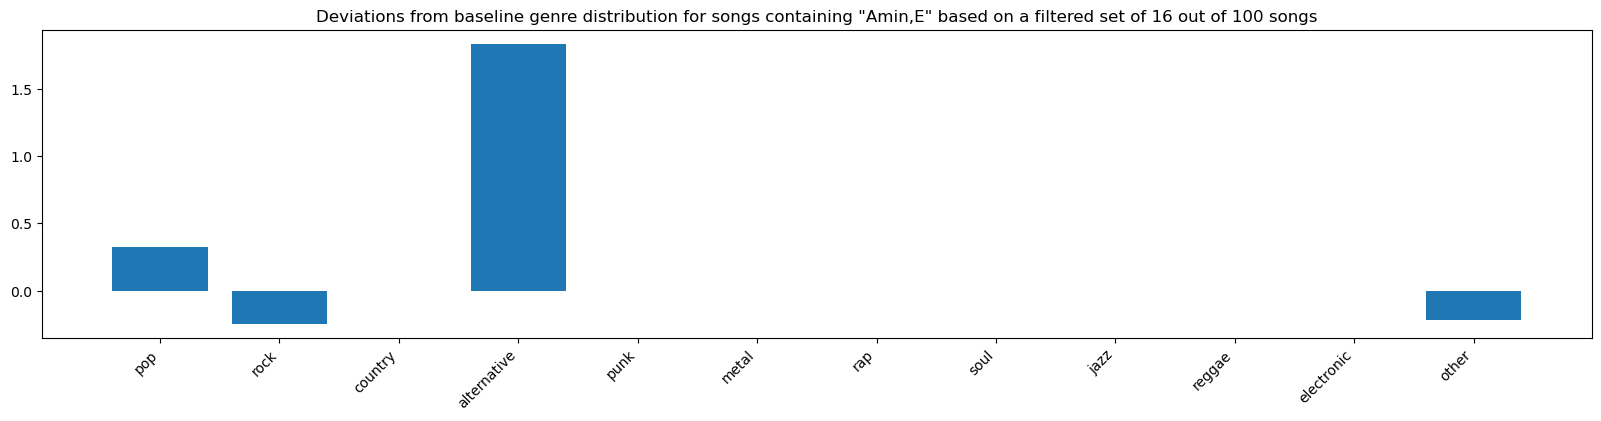

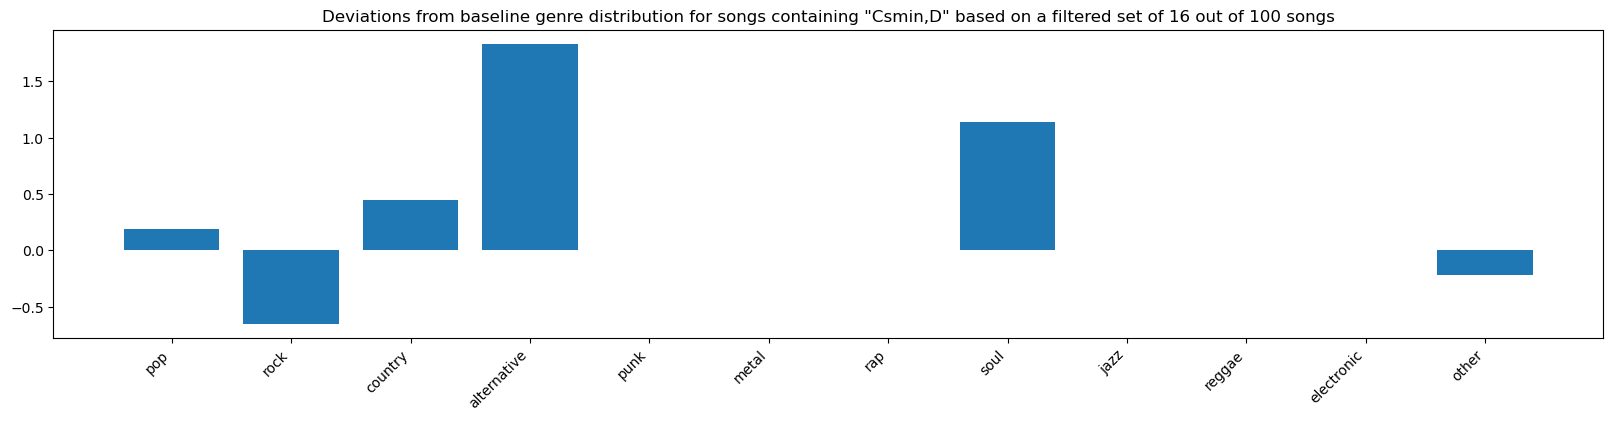

In [30]:
def plot_high_deviation_n_grams(deviation_df, sample_size_threshold = 0.1, how_many_to_plot = 10):
    # input: a dataframe with one row for a baseline, and one row per n_gram
    #        columns include n_gram, GENRE_abs_log_dev_ratio (for each major genre)
    # output: bar plots of the top n_grams, ranked by abs_log_dev_ratio
    df = copy.deepcopy(deviation_df)

    # drop all rows where the 'total' column doesn't meet the sample size threshold, which is sample_size_threshold times the baseline total value
    baseline_row_index = df.index[df['n_gram'] == 'baseline'][0]
    baseline_total = df.loc[baseline_row_index,'total']
    df = df[df.total >= baseline_total * sample_size_threshold]

    # drop the baseline row
    df = df[df.n_gram != 'baseline']
      
    # sort by max_abs_log_dev_ratio, descending so the big ones are at the top. Get those top rows.
    df = df.sort_values(by = 'max_abs_log_dev_ratio', ascending = False)
    how_many_to_plot = min(how_many_to_plot, len(df.index)) # don't try to plot more than all the rows
    top_rows = df.head(how_many_to_plot)
    
    for i in range(how_many_to_plot):
        row_i = df.iloc[i]
        height_data = [row_i[g + '_log_dev_ratio'] for g in major_genres]
        my_x = np.arange(len(major_genres))
        plt.figure(figsize = (20, 4))
        plt.bar(x = my_x,
                height = height_data)
        plt.xticks(my_x, major_genres, rotation = 45, ha = 'right')
        plt.title('Deviations from baseline genre distribution for songs containing "' + row_i['n_gram'] + '" based on a filtered set of ' + str(row_i['total']) + ' out of ' + str(baseline_total) + ' songs')
        plt.show()

sample_data = chord_data.sample(100)
empty_df = build_empty_df(sample_data, n=2)
raw_counts_df = compute_raw_counts(data = sample_data, df = empty_df, rows_to_compute = -1)
relative_df = add_relative_columns(raw_counts_df)
deviation_df = add_deviation_columns(relative_df)
pop_columns = ['n_gram', 'pop_raw', 'pop_rel', 'pop_dev_ratio', 'pop_log_dev_ratio', 'pop_abs_log_dev_ratio', 'total', 'counts_completed', 'max_abs_log_dev_ratio', 'mean_abs_log_dev_ratio']
display(deviation_df[pop_columns].head(10))
plot_high_deviation_n_grams(deviation_df, sample_size_threshold = 0.15, how_many_to_plot = 2)

In [31]:
# run this code snippet to partially complete the counts in the database
def run_tabulations(n, iterations, rows_per_iteration):
    filename = str(n) + '_gram_deviations.csv'
    print("Running tabulations on " + str(n) + "-gram dataframe.")
    print("Will run " + str(iterations) + " iterations, doing calculations on " + str(rows_per_iteration) + " rows per iteration.")
    print()
    
    time_vector = [0]*iterations
    
    for i in range(iterations):
        
        print("Iteration i =",i+1)
        t0 = time.time()
        
        print("Loading dataframe from csv.")
        df_loaded = pd.read_csv(filename)

        print("Current dataframe contains: ")
        #print("\t" + str(len(df_loaded.index)) + " total rows")
        print("\t" + str(df_loaded['counts_completed'].sum()) + " completed rows")
        remaining_rows = (len(df_loaded.index)) - df_loaded['counts_completed'].sum()
        print("\t" + str(remaining_rows) + " remaining rows")
    
        df_updated = compute_raw_counts(data = chord_data, df = df_loaded, rows_to_compute = rows_per_iteration)
        print('Completed tabulation for ' + str(rows_per_iteration) + ' rows.')
        
        print('Saving dataframe to csv.')
        df_updated.to_csv(filename,sep=',',index=False)
        
        t1 = time.time()
        time_vector[i] = t1-t0
        print("Time spent this iteration:",t1-t0,"seconds")
        print("Time per row this iteration:",(t1-t0)/rows_per_iteration,"seconds")
        print()

        # if there are less remaining rows than the next iteration would tabulate, 
        # just change the number of rows to do in the next iteration to be all of them
        if df_loaded['counts_completed'].sum() == 0:
            break
            if (len(df_loaded.index)) - df_loaded['counts_completed'].sum() < rows_per_iteration:
                rows_per_iteration = (len(df_loaded.index)) - df_loaded['counts_completed'].sum()
    
    print("Finished all iterations.")
    print("Total time:",np.sum(time_vector))
    print("Average time per iteration:",np.mean(time_vector))
    print("Average time per row:",np.mean(time_vector)/rows_per_iteration)
    
    remaining_rows = (len(df_loaded.index)) - df_loaded['counts_completed'].sum()
    print("Remaining rows:",remaining_rows)
    return remaining_rows

In [32]:
#######################################################################
#### populate a "blank" 1-grams csv data file 
#### DO NOT RUN THIS AGAIN, IT WILL OVERWRITE THE TABULATION WORK
#######################################################################
#n=1
#blank_df = build_empty_df(chord_data, n, progress_updates = True, progress_spacing = 5000)
#blank_df.to_csv(str(n) + '_gram_deviations.csv', sep=',', index=False)
#######################################################################

In [33]:
#######################################################################
#### populate a "blank" 2-grams csv data file 
#### DO NOT RUN THIS AGAIN, IT WILL OVERWRITE THE TABULATION WORK
#######################################################################
#n=2
#blank_df = build_empty_df(chord_data, n, progress_updates = True, progress_spacing = 5000)
#blank_df.to_csv(str(n) + '_gram_deviations.csv', sep=',', index=False)
#######################################################################

In [34]:
#######################################################################
#### populate a "blank" 3-grams csv data file 
#### I have still not run this yet, I anticipate it will take a long time
#######################################################################
#n=3
#blank_df = build_empty_df(chord_data, n, progress_updates = True, progress_spacing = 5000)
#blank_df.to_csv(str(n) + '_gram_deviations.csv', sep=',', index=False)
#######################################################################

In [48]:
remaining_rows = run_tabulations(n=2, iterations=10, rows_per_iteration=10)

Running tabulations on 2-gram dataframe.
Will run 10 iterations, doing calculations on 10 rows per iteration.

Iteration i = 1
Loading dataframe from csv.
Current dataframe contains: 
	2214 completed rows
	4137 remaining rows
Completed tabulation for 10 rows.
Saving dataframe to csv.
Time spent this iteration: 692.644455909729 seconds
Time per row this iteration: 69.2644455909729 seconds

Iteration i = 2
Loading dataframe from csv.
Current dataframe contains: 
	2224 completed rows
	4127 remaining rows
Completed tabulation for 10 rows.
Saving dataframe to csv.
Time spent this iteration: 590.9812753200531 seconds
Time per row this iteration: 59.09812753200531 seconds

Iteration i = 3
Loading dataframe from csv.
Current dataframe contains: 
	2234 completed rows
	4117 remaining rows
Completed tabulation for 10 rows.
Saving dataframe to csv.
Time spent this iteration: 596.5589971542358 seconds
Time per row this iteration: 59.65589971542359 seconds

Iteration i = 4
Loading dataframe from csv

KeyboardInterrupt: 

In [42]:
# only run this after all rows are tabulated
# this will add the columsn for relative counts, relative deviations, log relative deviations, and key summary statistic columsn (main one being the absolute relative log deviation)
def process_tabulated_df(n):
    filename = str(n) + '_gram_deviations.csv'
    raw_counts_df = pd.read_csv(filename)
    relative_df = add_relative_columns(raw_counts_df)
    deviation_df = add_deviation_columns(relative_df)
    deviation_df.to_csv(filename,sep=',',index=False)
    return deviation_df

In [ ]:
#######################################################################
#### NO NEED TO RUN THIS AGAIN
#process_tabulated_df(1)
#######################################################################

In [44]:
#################################################################################
#### RUN THIS AGAIN AFTER FINISHING TABULATIONS
# process_tabulated_df(2)
#################################################################################

,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,...,reggae_log_dev_ratio,reggae_abs_log_dev_ratio,electronic_dev_ratio,electronic_log_dev_ratio,electronic_abs_log_dev_ratio,other_dev_ratio,other_log_dev_ratio,other_abs_log_dev_ratio,max_abs_log_dev_ratio,mean_abs_log_dev_ratio
0,baseline,131247,81276,15884,4358,10060,3007,4013,2909,1857,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,"C,F",92276,57275,13287,2651,7242,1832,1913,1806,1123,...,-0.246464,0.246464,0.740695,-0.300166,0.300166,1.026943,0.026586,0.026586,0.399729,0.147979
2,"F,C",94559,59379,13617,2882,7671,2113,2090,1742,1111,...,-0.261284,0.261284,0.886621,-0.120338,0.120338,1.002434,0.002431,0.002431,0.332713,0.121593
3,"C,E7",3323,1802,310,71,130,41,79,106,90,...,-0.483688,0.483688,0.348411,-1.054374,1.054374,1.278188,0.245444,0.245444,1.054374,0.447509
4,"E7,Amin",8916,4529,578,223,287,112,221,248,267,...,-0.492682,0.492682,0.698255,-0.359171,0.359171,1.285060,0.250805,0.250805,0.873322,0.407693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6346,"Aminadd11,Cno3d",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6347,"Gmin11,Adim",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6348,"Bbminadd9,Eb7b9",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6349,"Eb7b9,Cdim7",0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#################################################################################
#### ONLY USEFUL TO RUN AFTER TABULATING SOME GENRE COUNTS FOR 3-GRAMS
#process_tabulated_df(3)
#################################################################################